In [12]:
import numpy as np
import matplotlib.pyplot as plt
from generate_magnetic_field import get_mag_field
from create_poly_lib import get_poly_lib

In [5]:
# genrate coordinate mesh 
x_data_points = 11
x_array = np.linspace(-1,1,x_data_points)
x_array
xv,yv,zv = np.meshgrid(x_array,x_array,x_array,indexing='ij')

In [6]:
# create BV mask 
xyv_mask    = ((xv==-1) + (xv==0) + (xv==1)) * ((yv==-1) + (yv==0) + (yv==1))
zv_mask     = (zv==-1) + (zv ==1) + (zv==0)
center_mask = (xv==0)*(yv==0)*(zv==0)
bv_mask     = (xyv_mask) * (zv_mask)* (~center_mask)

In [10]:
# calculate B(B_x,B_y,B_z) field at x,y,z meshgrid 
B = get_mag_field(2,xv,yv,zv)       # get B at x,y,z mesh 
B = B.reshape(*xv.shape,3)          # reshape B to have shape as coordinate mesh 
Bv = B[bv_mask]                     # get the BV (26 values)
B[~bv_mask] = 0                     # set phyics BV =0 

In [11]:
Bv

array([[-4.3300e-02, -2.3550e-02,  9.5380e-01],
       [-2.5400e-02,  1.2450e-02,  9.2760e-01],
       [ 7.1000e-03,  5.9650e-02,  9.0820e-01],
       [-5.0175e-02, -1.9900e-02,  9.7690e-01],
       [-2.3275e-02,  1.5000e-03,  9.6190e-01],
       [ 1.8225e-02,  3.4100e-02,  9.5370e-01],
       [-6.4100e-02, -2.9250e-02,  9.8540e-01],
       [-2.8200e-02, -2.2450e-02,  9.8160e-01],
       [ 2.2300e-02, -4.4500e-03,  9.8460e-01],
       [-2.7625e-02, -2.6000e-02,  9.6830e-01],
       [-1.9250e-03,  1.9000e-02,  9.5670e-01],
       [ 3.8375e-02,  7.5200e-02,  9.5190e-01],
       [-3.2700e-02, -2.9400e-02,  1.0004e+00],
       [ 5.1300e-02,  4.2600e-02,  1.0064e+00],
       [-4.4825e-02, -4.5800e-02,  1.0179e+00],
       [-1.1250e-03, -3.0000e-02,  1.0287e+00],
       [ 5.7175e-02, -3.0000e-03,  1.0463e+00],
       [-1.9500e-02, -2.6650e-02,  9.9060e-01],
       [ 1.4000e-02,  2.7350e-02,  9.9360e-01],
       [ 6.2100e-02,  9.2550e-02,  1.0034e+00],
       [-2.2775e-02, -3.7100e-02,  1.031

In [8]:
# bv coordinates 
Bv_coords = np.array([xv[bv_mask],yv[bv_mask],zv[bv_mask]]).T
Bv_coords

array([[-1., -1., -1.],
       [-1., -1.,  0.],
       [-1., -1.,  1.],
       [-1.,  0., -1.],
       [-1.,  0.,  0.],
       [-1.,  0.,  1.],
       [-1.,  1., -1.],
       [-1.,  1.,  0.],
       [-1.,  1.,  1.],
       [ 0., -1., -1.],
       [ 0., -1.,  0.],
       [ 0., -1.,  1.],
       [ 0.,  0., -1.],
       [ 0.,  0.,  1.],
       [ 0.,  1., -1.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  1.],
       [ 1., -1., -1.],
       [ 1., -1.,  0.],
       [ 1., -1.,  1.],
       [ 1.,  0., -1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  1.],
       [ 1.,  1., -1.],
       [ 1.,  1.,  0.],
       [ 1.,  1.,  1.]])

In [13]:
X = get_poly_lib(4,Bv_coords)

In [18]:
w = np.linalg.lstsq(X,Bv,rcond=None)[0]
w

array([[ 2.00000000e-03,  1.00000000e-03,  1.00000000e+00],
       [ 1.07500000e-02,  2.00000000e-04,  2.10000000e-02],
       [ 2.00000000e-04, -1.22500000e-02,  1.80000000e-02],
       [ 2.10000000e-02,  1.80000000e-02,  1.50000000e-03],
       [-1.88750000e-03,  4.50000000e-04,  1.95000000e-03],
       [ 6.00000000e-04, -2.35000000e-03,  3.00000000e-03],
       [ 2.60000000e-03,  3.00000000e-03,  4.86666667e-03],
       [-1.76250000e-03, -3.25000000e-03, -3.65000000e-03],
       [ 3.00000000e-03, -4.86666667e-03,  3.73333333e-03],
       [ 3.65000000e-03,  2.80000000e-03,  1.70000000e-03],
       [ 1.07500000e-02,  2.00000000e-04,  2.10000000e-02],
       [ 2.05983265e-17, -1.82160981e-18,  1.66687688e-16],
       [-1.20361589e-17,  3.05729997e-18,  1.54234713e-19],
       [ 1.47436348e-17, -5.77894774e-18, -5.53569165e-17],
       [-3.03728087e-18, -2.07951478e-17,  8.34209616e-17],
       [-3.36254153e-18,  6.74358735e-18,  8.34209616e-17],
       [ 2.00000000e-04, -1.22500000e-02

In [23]:
lam = 1e-3
small_ind = w < lam
w[small_ind] = 0
w

array([[0.002     , 0.001     , 1.        ],
       [0.01075   , 0.        , 0.021     ],
       [0.        , 0.        , 0.018     ],
       [0.021     , 0.018     , 0.0015    ],
       [0.        , 0.        , 0.00195   ],
       [0.        , 0.        , 0.003     ],
       [0.0026    , 0.003     , 0.00486667],
       [0.        , 0.        , 0.        ],
       [0.003     , 0.        , 0.00373333],
       [0.00365   , 0.0028    , 0.0017    ],
       [0.01075   , 0.        , 0.021     ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.018     ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.021     , 0.018     , 0.0015    ],
       [0.        , 0.        , 0.00195   ],
       [0.        , 0.        , 0.003     ],
       [0.

In [63]:
def SYNDy(X,Bv,lam):
    w = np.linalg.lstsq(X,Bv,rcond=None)[0]
    for i in range(10):
        small_ind = w < lam
        w[small_ind] = 0
        for ind in range(3):
            big_ind = ~small_ind[:,ind]
            w[big_ind,ind] = np.linalg.lstsq(X[:,big_ind],Bv[:,ind],rcond=None)[0]
    return w

In [64]:
w_mod = SYNDy(X,Bv,1e-3)
w_mod

array([[0.        , 0.        , 0.99402727],
       [0.01075   , 0.        , 0.021     ],
       [0.        , 0.        , 0.018     ],
       [0.021     , 0.018     , 0.0015    ],
       [0.        , 0.        , 0.00228182],
       [0.        , 0.        , 0.003     ],
       [0.0026    , 0.003     , 0.00486667],
       [0.        , 0.        , 0.        ],
       [0.003     , 0.        , 0.00373333],
       [0.00221667, 0.00143333, 0.00203182],
       [0.01075   , 0.        , 0.021     ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.018     ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.021     , 0.018     , 0.0015    ],
       [0.        , 0.        , 0.00228182],
       [0.        , 0.        , 0.003     ],
       [0.

In [6]:
# physics BV coords 
PBv_coords = np.array([xv[~bv_mask],yv[~bv_mask],zv[~bv_mask]]).T

tensor([[-1.0000, -1.0000, -0.8000],
        [-1.0000, -1.0000, -0.6000],
        [-1.0000, -1.0000, -0.4000],
        ...,
        [ 1.0000,  1.0000,  0.4000],
        [ 1.0000,  1.0000,  0.6000],
        [ 1.0000,  1.0000,  0.8000]], requires_grad=True)

In [34]:
z_axis_mask = (xv==0) * (yv==0)     # mask to select data along z axis 
B = get_mag_field(2,xv,yv,zv)       # get B at x,y,z mesh 
B = B.reshape(*xv.shape,3)          # reshape B to have shape as coordinate mesh 
Bz = B[z_axis_mask]                 # Bz along z axis 
Bz

array([[-3.270000e-02, -2.940000e-02,  1.000400e+00],
       [-2.692800e-02, -2.421600e-02,  9.997760e-01],
       [-2.057200e-02, -1.858400e-02,  9.994240e-01],
       [-1.363200e-02, -1.250400e-02,  9.993440e-01],
       [-6.108000e-03, -5.976000e-03,  9.995360e-01],
       [ 2.000000e-03,  1.000000e-03,  1.000000e+00],
       [ 1.069200e-02,  8.424000e-03,  1.000736e+00],
       [ 1.996800e-02,  1.629600e-02,  1.001744e+00],
       [ 2.982800e-02,  2.461600e-02,  1.003024e+00],
       [ 4.027200e-02,  3.338400e-02,  1.004576e+00],
       [ 5.130000e-02,  4.260000e-02,  1.006400e+00]])

Text(0, 0.5, '$B_y$')

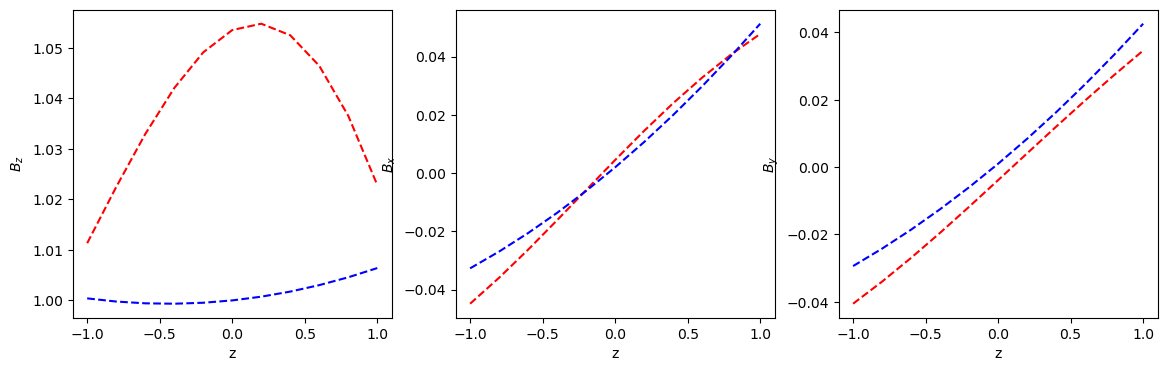

In [33]:
# plot the magnetic field 
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(14, 4))

ax1.plot(z[:,2],Bz_pred[:,2],'r--',label='pred')
ax1.plot(z[:,2],Bz[:,2],'b--',label='actaul')
ax1.set_xlabel('z')
ax1.set_ylabel(r'$B_z$')

ax2.plot(z[:,2],Bz_pred[:,0],'r--',label='pred')
ax2.plot(z[:,2],Bz[:,0],'b--',label='actaul')
ax2.set_xlabel('z')
ax2.set_ylabel(r'$B_x$')

ax3.plot(z[:,2],Bz_pred[:,1],'r--',label='pred')
ax3.plot(z[:,2],Bz[:,1],'b--',label='actaul')
ax3.set_xlabel('z')
ax3.set_ylabel(r'$B_y$')